In [19]:
pip install dtaidistance

In [20]:
import math, time, re
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from dtaidistance import dtw
import matplotlib.pyplot as plt

In [21]:
BASE_DIR=Path("/content/drive/MyDrive/Dance_clean_data")

In [22]:
SEQ_IN,SEQ_OUT=30,30
BATCH=128
EPOCHS=10
LR=3e-4
WDECAY=1e-4
D_MODEL=128
NHEAD=8
N_ENC=2
N_DEC=2
DROPOUT=0.1
VEL_W=0.1
GRAD_CLIP=1.0
WINDOW_STRIDE_EVAL=10
MAX_EVAL_WINDOWS=20000
MAX_DTW_SAMPLES=64

In [23]:
DEVICE=torch.device("cuda" if torch.cuda.is_available() else "cpu")
AMP=torch.cuda.is_available()
torch.backends.cudnn.benchmark=True
try: torch.set_float32_matmul_precision('high')
except: pass

In [24]:
def dancer_from_path(p: Path):
    m=re.match(r"^(D\d+)",p.parent.name)
    return m.group(1) if m else p.parent.name

def load_npy_by_pattern(base_dir: Path,ps: str,edim=None):
    b={}
    for f in base_dir.rglob("*.npy"):
        if ps.lower() not in f.name.lower():
            continue
        arr=np.load(f)
        if arr.ndim!=2:
            continue
        if edim is not None and arr.shape[1]!=edim:
            continue
        d=dancer_from_path(f)
        b.setdefault(d, []).append(arr.astype(np.float32))
    return b

def vstack_or_empty(la,D=None):
    if not la:
        return np.empty((0, D if D is not None else 0),np.float32)
    return np.vstack(la).astype(np.float32)


In [25]:
def build_io(data_2d,in_len=30,out_len=30,feat_dim=None,stride=1):
    T=len(data_2d)
    if feat_dim is None: feat_dim=data_2d.shape[1] if data_2d.ndim==2 else 0
    if T<in_len+out_len:
        return (np.empty((0,in_len,feat_dim),np.float32),
                np.empty((0,out_len,feat_dim),np.float32))
    X,Y=[],[]
    for i in range(0,T-in_len-out_len+1,stride):
        X.append(data_2d[i:i+in_len])
        Y.append(data_2d[i+in_len:i+in_len+out_len])
    return np.stack(X).astype(np.float32),np.stack(Y).astype(np.float32)

In [26]:
def fit_scaler(X_windows):
    sc=StandardScaler().fit(X_windows.reshape(-1, X_windows.shape[-1]))
    mu,sig=sc.mean_.astype(np.float32),sc.scale_.astype(np.float32)
    sig[sig==0]=1.0
    return mu, sig

def transform_safe(x,mu,sig): return (x - mu)/sig
def inv_transform_safe(x, mu, sig): return x*sig+mu

In [27]:
def gen_mask(sz,device):
    m=torch.full((sz,sz),float('-inf'),device=device)
    m=torch.triu(m,diagonal=1)
    m=m.masked_fill(m==0,0.0)
    return m

In [28]:
class PositionalEncoding(nn.Module):
    def __init__(self,d_model,max_len=2048):
        super().__init__()
        pe=torch.zeros(max_len,d_model)
        pos=torch.arange(0,max_len,dtype=torch.float32).unsqueeze(1)
        div=torch.exp(torch.arange(0,d_model,2).float()*(-math.log(10000.0)/d_model))
        pe[:,0::2]=torch.sin(pos*div)
        pe[:,1::2]=torch.cos(pos*div)
        self.register_buffer("pe",pe.unsqueeze(0))
    def forward(self,x):
        return x+self.pe[:,:x.size(1)]


In [29]:
class Transformer(nn.Module):
    def __init__(self,input_dim,d_model=D_MODEL,nhead=NHEAD,num_enc=N_ENC,num_dec=N_DEC,dropout=DROPOUT,seq_out=SEQ_OUT):
        super().__init__()
        self.seq_out=seq_out
        self.in_proj=nn.Linear(input_dim,d_model)
        self.out_proj=nn.Linear(d_model,input_dim)
        self.pos_enc=PositionalEncoding(d_model)
        enc_layer=nn.TransformerEncoderLayer(d_model,nhead,dim_feedforward=4*d_model,dropout=dropout,batch_first=True)
        dec_layer=nn.TransformerDecoderLayer(d_model,nhead,dim_feedforward=4*d_model,dropout=dropout,batch_first=True)
        self.encoder=nn.TransformerEncoder(enc_layer,num_layers=num_enc)
        self.decoder=nn.TransformerDecoder(dec_layer,num_layers=num_dec)
        self.cached_mask=None
        self.cached_len=0

    def _get_tgt_mask(self,L,device):
        if self.cached_mask is None or self.cached_len < L or self.cached_mask.device != device:
            self.cached_mask=gen_mask(L,device)
            self.cached_len=L
        return self.cached_mask[:L,:L]

    def velocity(self, x):
        return x[:,1:,:]-x[:,:-1,:]

    def forward_train(self,src,tgt):
        mem=self.encoder(self.pos_enc(self.in_proj(src)))
        start=src[:, -1:, :]
        dec_in=torch.cat([start,tgt[:, :-1, :]],dim=1)
        dec_e=self.pos_enc(self.in_proj(dec_in))
        mask=self._get_tgt_mask(dec_e.size(1),dec_e.device)
        dec_h=self.decoder(dec_e,mem,tgt_mask=mask)
        return self.out_proj(dec_h)

    @torch.no_grad()
    def forward_eval(self,src):
        mem=self.encoder(self.pos_enc(self.in_proj(src)))
        dec_abs=src[:,-1:,:]
        outs=[]
        for _ in range(self.seq_out):
            dec_e=self.pos_enc(self.in_proj(dec_abs))
            mask=self._get_tgt_mask(dec_e.size(1),dec_e.device)
            dec_h=self.decoder(dec_e,mem,tgt_mask=mask)
            next_abs=self.out_proj(dec_h[:, -1:, :])
            outs.append(next_abs)
            dec_abs=torch.cat([dec_abs,next_abs],dim=1)
        return torch.cat(outs,dim=1)

In [30]:
def train_transformer(X_tr,Y_tr,X_val,Y_val,d_feat):
    model=Transformer(input_dim=d_feat).to(DEVICE)
    opt=torch.optim.AdamW(model.parameters(),lr=LR,weight_decay=WDECAY)
    loss_pos=nn.SmoothL1Loss()
    scaler=torch.amp.GradScaler("cuda",enabled=AMP)

    def velocity(x): return x[:,1:,:]-x[:,:-1,:]

    train_loader=DataLoader(TensorDataset(torch.tensor(X_tr),torch.tensor(Y_tr)),batch_size=BATCH,shuffle=True,drop_last=True)
    val_loader=DataLoader(TensorDataset(torch.tensor(X_val),torch.tensor(Y_val)),batch_size=BATCH,shuffle=False,drop_last=False)

    print("\nTraining:")
    for ep in range(1, EPOCHS+1):
        model.train(); tot=0.0; t0=time.time()
        for xb,yb in train_loader:
            xb=xb.to(DEVICE); yb=yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            with torch.amp.autocast("cuda", enabled=AMP):
                pred=model.forward_train(xb, yb)
                loss=loss_pos(pred, yb)+VEL_W*loss_pos(velocity(pred),velocity(yb))
            scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(model.parameters(),GRAD_CLIP)
            scaler.step(opt); scaler.update()
            tot+=loss.item()

        model.eval(); vtot=0.0
        with torch.no_grad(), torch.amp.autocast("cuda",enabled=AMP):
            for xb,yb in val_loader:
                xb=xb.to(DEVICE); yb=yb.to(DEVICE)
                pred=model.forward_eval(xb)
                vtot+=(loss_pos(pred, yb)+VEL_W*loss_pos(velocity(pred),velocity(yb))).item()

        print(f"Epoch {ep:02d} | Train: {tot/len(train_loader):.5f}  Val: {vtot/len(val_loader):.5f}")
    return model


In [31]:
@torch.no_grad()
def evaluate(model,X,Y,name="",max_dtw=MAX_DTW_SAMPLES):
    if len(X)==0:
        print(f"{name}: no windows."); return None
    Xt=torch.tensor(X,dtype=torch.float32,device=DEVICE)
    with torch.amp.autocast("cuda", enabled=AMP):
        pred=model.forward_eval(Xt).cpu().numpy()
    gt=Y
    l1=float(np.mean(np.abs(pred-gt)))
    l2=float(np.mean((pred-gt)**2))
    k=min(len(gt), max_dtw)
    dvals=[dtw.distance(pred[i].reshape(-1),gt[i].reshape(-1)) for i in range(k)]
    print(f"{name}: L1={l1:.4f}  L2={l2:.4f}  DTW(n={k})={np.mean(dvals):.4f}")
    return {"l1": l1, "l2": l2, "dtw": float(np.mean(dvals))}


In [32]:
def windows_eval(long_arr,mu,sig,d_feat,name):
    Xr,Yr=build_io(long_arr,SEQ_IN,SEQ_OUT,feat_dim=d_feat,stride=WINDOW_STRIDE_EVAL)
    if Xr.size==0:
        #print(f"[eval-build] {name}: 0 windows")
        return (np.empty((0,SEQ_IN,d_feat),np.float32),np.empty((0,SEQ_OUT,d_feat),np.float32))
    if len(Xr)>MAX_EVAL_WINDOWS:
        idx=np.linspace(0,len(Xr)-1,num=MAX_EVAL_WINDOWS,dtype=int)
        Xr,Yr=Xr[idx],Yr[idx]
    Xs=transform_safe(Xr,mu,sig); Ys=transform_safe(Yr,mu,sig)
    #print(f"[eval-build] {name}: {Xs.shape} windows (stride={WINDOW_STRIDE_EVAL}, cap={MAX_EVAL_WINDOWS})")
    return Xs,Ys

In [33]:
train_by_d=load_npy_by_pattern(BASE_DIR,"train")
zig_by_d=load_npy_by_pattern(BASE_DIR,"zigzag")
circ_by_d=load_npy_by_pattern(BASE_DIR,"circle")
all_dancers=sorted(set(train_by_d) | set(zig_by_d) | set(circ_by_d))

def concat_all(b):
    if not b: return np.empty((0,0),np.float32)
    any_d=next(iter(b))
    Ddim=b[any_d][0].shape[1]
    return vstack_or_empty([arr for d in b for arr in b.get(d, [])], D=Ddim)

train_all=concat_all(train_by_d)
zig_all=concat_all(zig_by_d)
circ_all=concat_all(circ_by_d)

print("Shapes–train:", train_all.shape, " zig:", zig_all.shape, " circle:", circ_all.shape)
if train_all.size==0:
    raise RuntimeError("No 'train' .npy found.")
D=train_all.shape[1]

Shapes–train: (331508, 112)  zig: (132034, 112)  circle: (138524, 112)


In [34]:
Xtr_raw,Ytr_raw=build_io(train_all,SEQ_IN,SEQ_OUT,feat_dim=D,stride=1)
print(f"Train windows:", Xtr_raw.shape, Ytr_raw.shape)

n=len(Xtr_raw)
if n==0: raise RuntimeError("No windows constructed from train data.")
n_val=max(int(0.1*n), 1)
Xtr_raw,Ytr_raw,Xval_raw,Yval_raw=Xtr_raw[:-n_val],Ytr_raw[:-n_val],Xtr_raw[-n_val:],Ytr_raw[-n_val:]
print(f"Split-Train: {len(Xtr_raw)}  Val: {len(Xval_raw)}")


Train windows: (331449, 30, 112) (331449, 30, 112)
Split-Train: 298305  Val: 33144


In [35]:
mu,sig=fit_scaler(Xtr_raw)
Xtr=transform_safe(Xtr_raw,mu,sig);  Ytr=transform_safe(Ytr_raw,mu,sig)
Xval=transform_safe(Xval_raw,mu,sig); Yval = transform_safe(Yval_raw,mu,sig)


In [36]:
model_all=train_transformer(Xtr,Ytr,Xval,Yval,d_feat=D)

Xs_tr,Ys_tr=windows_eval(train_all, mu, sig, D, "Train")
evaluate(model_all,Xs_tr,Ys_tr,name=" Train(")

Xs_zig,Ys_zig=windows_eval(zig_all,mu,sig,D, "Zigzag")
Xs_cir,Ys_cir=windows_eval(circ_all,mu,sig,D, "Circle")

evaluate(model_all,Xs_zig,Ys_zig,name="Zigzag")
evaluate(model_all,Xs_cir,Ys_cir,name="Circle")


Training:
Epoch 01 | Train: 0.01151  Val: 0.02068
Epoch 02 | Train: 0.00120  Val: 0.01775
Epoch 03 | Train: 0.00072  Val: 0.01839
Epoch 04 | Train: 0.00056  Val: 0.01709
Epoch 05 | Train: 0.00049  Val: 0.01620
Epoch 06 | Train: 0.00045  Val: 0.01684
Epoch 07 | Train: 0.00043  Val: 0.01788
Epoch 08 | Train: 0.00042  Val: 0.01345
Epoch 09 | Train: 0.00041  Val: 0.01415
Epoch 10 | Train: 0.00040  Val: 0.01327
 Train(: L1=0.0593  L2=0.0218  DTW(n=64)=3.6691
Zigzag: L1=0.1314  L2=0.0728  DTW(n=64)=5.5069
Circle: L1=0.1074  L2=0.0378  DTW(n=64)=6.4447


{'l1': 0.10743670165538788, 'l2': 0.0378321148455143, 'dtw': 6.444730916660504}

In [37]:
@torch.no_grad()
def predict_transformer(arr,model,mu,sig,seq_in=SEQ_IN,seq_out=SEQ_OUT,batch_pred=256,step=1,device=DEVICE,):
    model.eval()
    T,D=arr.shape
    if T<=seq_in:
        raise ValueError("File too short to predict: T=seq_in")
    Xs=(arr-mu)/sig
    starts=np.arange(0,T-seq_in,step,dtype=np.int32)
    N=len(starts)
    pred_sum=np.zeros((T,D),dtype=np.float32)
    pred_count=np.zeros((T,),dtype=np.int32)

    for i in range(0,N,batch_pred):
        j=min(N,i+batch_pred)
        bs=j-i
        st=starts[i:j]
        ctx_batch=np.stack([Xs[s:s+seq_in] for s in st],axis=0)
        xb=torch.tensor(ctx_batch,dtype=torch.float32,device=device)
        with torch.amp.autocast("cuda", enabled=torch.cuda.is_available()):
            pred=model.forward_eval(xb)
        pred=pred.detach().cpu().numpy()

        for b in range(bs):
            s0=st[b]
            L=min(seq_out,T-(s0+seq_in))
            if L<=0:
                continue
            t_slice=slice(s0+seq_in,s0+seq_in+L)
            pred_sum[t_slice]+=pred[b,:L,:]
            pred_count[t_slice]+=1

    valid=pred_count>0
    pred_full=np.zeros_like(arr,dtype=np.float32)
    if valid.any():
        den=pred_count[valid].astype(np.float32)[:,None]
        pred_full[valid]=(pred_sum[valid]/np.maximum(den,1.0))*sig+mu
    pred_full[:seq_in]=arr[:seq_in]
    return pred_full,valid


In [38]:
def _prep_xyz(gt,pred,xyz_idx=(0,1,2),normalize_to_last_context=True,ctx_len=30):
    xi,yi,zi=xyz_idx
    T=gt.shape[0]
    gt_xyz=gt[:,[xi,yi,zi]].astype(np.float32)
    pred_xyz=pred[:,[xi,yi,zi]].astype(np.float32)
    if normalize_to_last_context and T>ctx_len:
        origin=gt_xyz[ctx_len-1].copy()
        gt_xyz=gt_xyz-origin
        pred_xyz=pred_xyz-origin
        ctx_pt=np.zeros(3, np.float32); suffix=" (normalized to last context)"
    else:
        ctx_pt=gt_xyz[min(ctx_len-1, T-1)]; suffix=""
    return gt_xyz,pred_xyz,ctx_pt,suffix

In [39]:
def plot_3d(gt,pred,title="file",xyz_idx=(0,1,2),normalize_to_last_context=True,ctx_len=30,figsize=(12,9)):
    gt_xyz,pred_xyz,ctx_pt,suffix=_prep_xyz(gt,pred,xyz_idx,normalize_to_last_context,ctx_len)
    fig=plt.figure(figsize=figsize); ax=fig.add_subplot(111,projection='3d')
    ax.plot(gt_xyz[ctx_len:,0],gt_xyz[ctx_len:,1],gt_xyz[ctx_len:,2],'--',lw=2, label='GT')
    ax.plot(pred_xyz[ctx_len:,0],pred_xyz[ctx_len:,1],pred_xyz[ctx_len:,2],'-',lw=2, label='Pred')
    ax.scatter(ctx_pt[0],ctx_pt[1],ctx_pt[2],s=60,c='k',label='context end')
    ax.set_title(title+suffix); ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z'); ax.legend()
    try:
        mins=np.minimum(gt_xyz.min(0),pred_xyz.min(0)); maxs=np.maximum(gt_xyz.max(0),pred_xyz.max(0))
        ax.set_box_aspect((maxs-mins))
    except Exception: pass
    plt.tight_layout(); plt.show()

In [40]:
def plot_2d(gt,pred,title="file",xyz_idx=(0,1,2),normalize_to_last_context=True,ctx_len=30,figsize=(16,5)):
    gt_xyz,pred_xyz,ctx_pt,suffix=_prep_xyz(gt,pred,xyz_idx,normalize_to_last_context,ctx_len)
    fig,axes=plt.subplots(1,3,figsize=figsize)
    (ax_xy,ax_xz,ax_yz)=axes
    ax_xy.plot(gt_xyz[ctx_len:,0],gt_xyz[ctx_len:,1], '--', lw=2, label='GT')
    ax_xy.plot(pred_xyz[ctx_len:,0], pred_xyz[ctx_len:,1], '-',  lw=2, label='Pred')
    ax_xy.scatter(ctx_pt[0], ctx_pt[1], c='k', marker='x', s=50); ax_xy.set_title(f"{title} – X–Y{suffix}"); ax_xy.legend()

    ax_xz.plot(gt_xyz[ctx_len:,0], gt_xyz[ctx_len:,2], '--', lw=2, label='GT')
    ax_xz.plot(pred_xyz[ctx_len:,0], pred_xyz[ctx_len:,2], '-',  lw=2, label='Pred')
    ax_xz.scatter(ctx_pt[0], ctx_pt[2], c='k', marker='x', s=50); ax_xz.set_title("X–Z"); ax_xz.legend()

    ax_yz.plot(gt_xyz[ctx_len:,1], gt_xyz[ctx_len:,2], '--', lw=2, label='GT')
    ax_yz.plot(pred_xyz[ctx_len:,1], pred_xyz[ctx_len:,2], '-',  lw=2, label='Pred')
    ax_yz.scatter(ctx_pt[1], ctx_pt[2], c='k', marker='x', s=50); ax_yz.set_title("Y–Z"); ax_yz.legend()
    for ax in axes: ax.grid(True, alpha=0.2)
    plt.tight_layout(); plt.show()

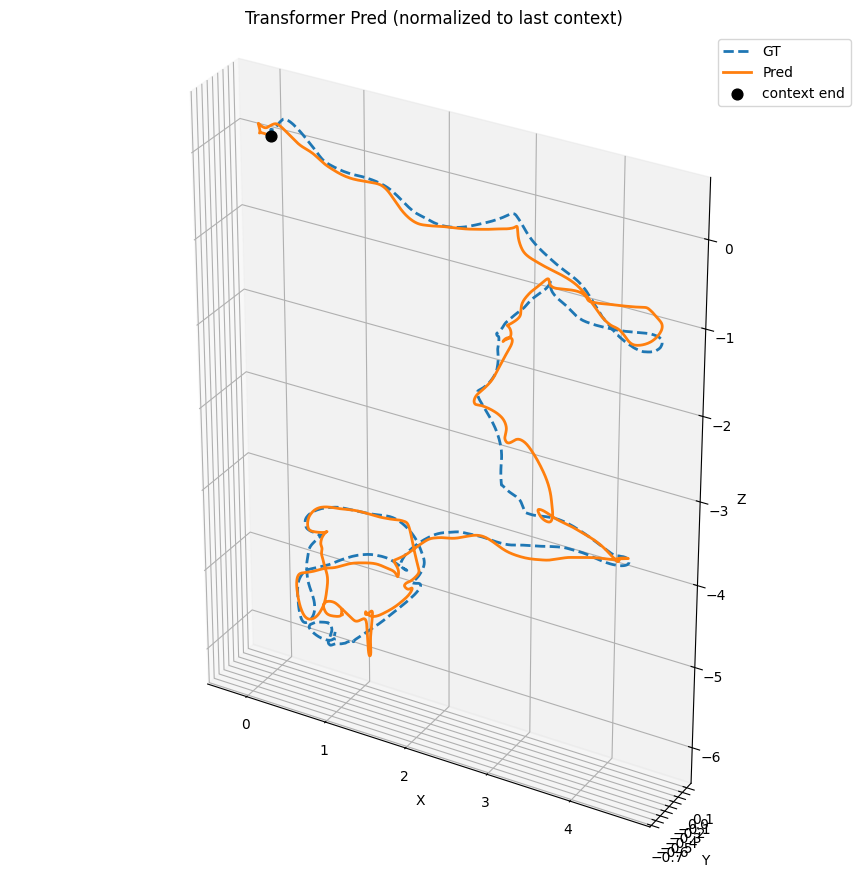

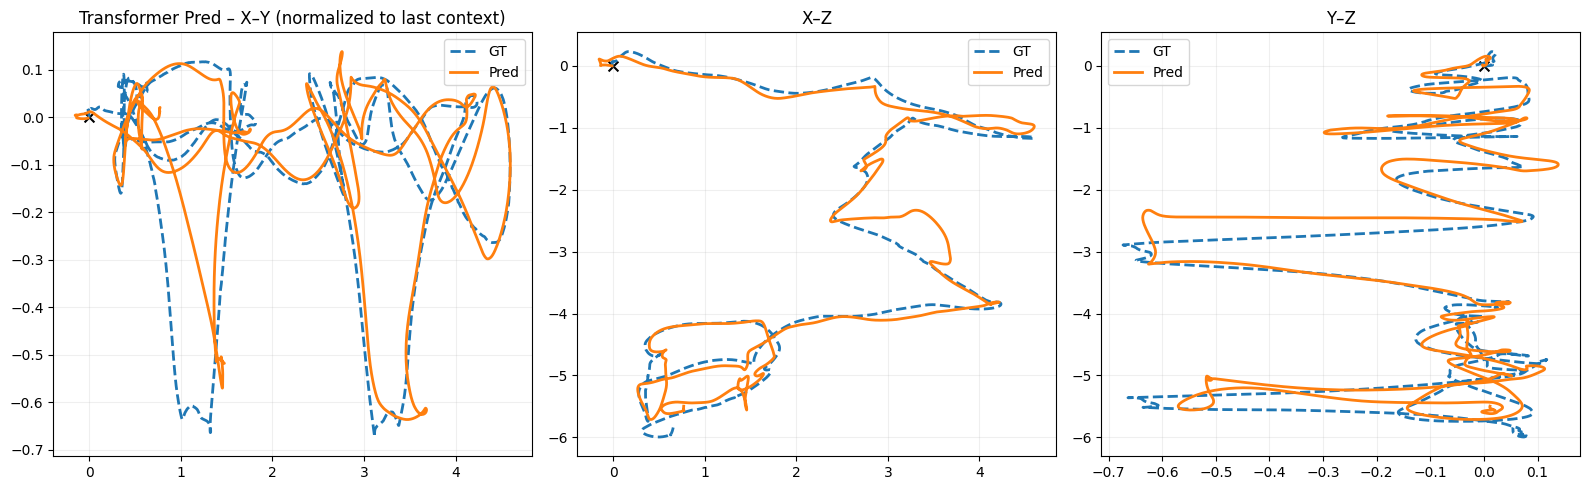

In [42]:
file_path = "/content/drive/MyDrive/Dance_clean_data/D1_All_CSVs/cleaned_Take 072817_Sub1_NewZigZag1 12.26.30 PM edit.npy"
arr = np.load(file_path).astype(np.float32)
pred, mask = predict_transformer(arr, model_all, mu, sig, seq_in=30, seq_out=30, step=1, device=DEVICE)
plot_3d(arr, pred, title="Transformer Pred", xyz_idx=(16,17,18), normalize_to_last_context=True, ctx_len=30)
plot_2d(arr, pred, title="Transformer Pred", xyz_idx=(16,17,18), normalize_to_last_context=True, ctx_len=30)

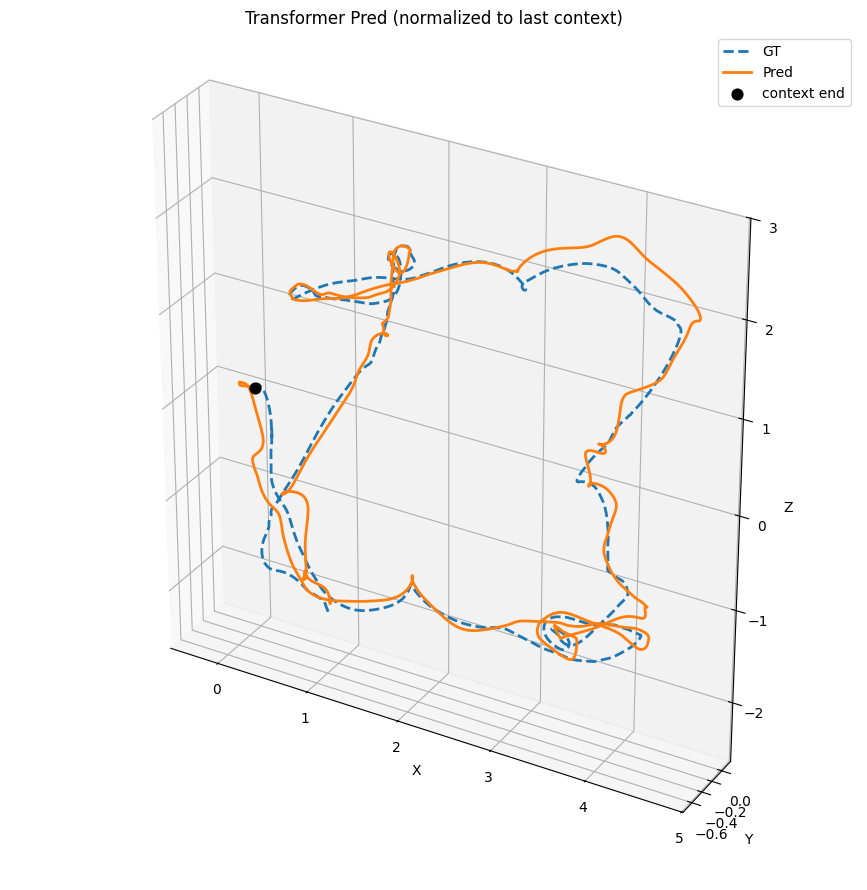

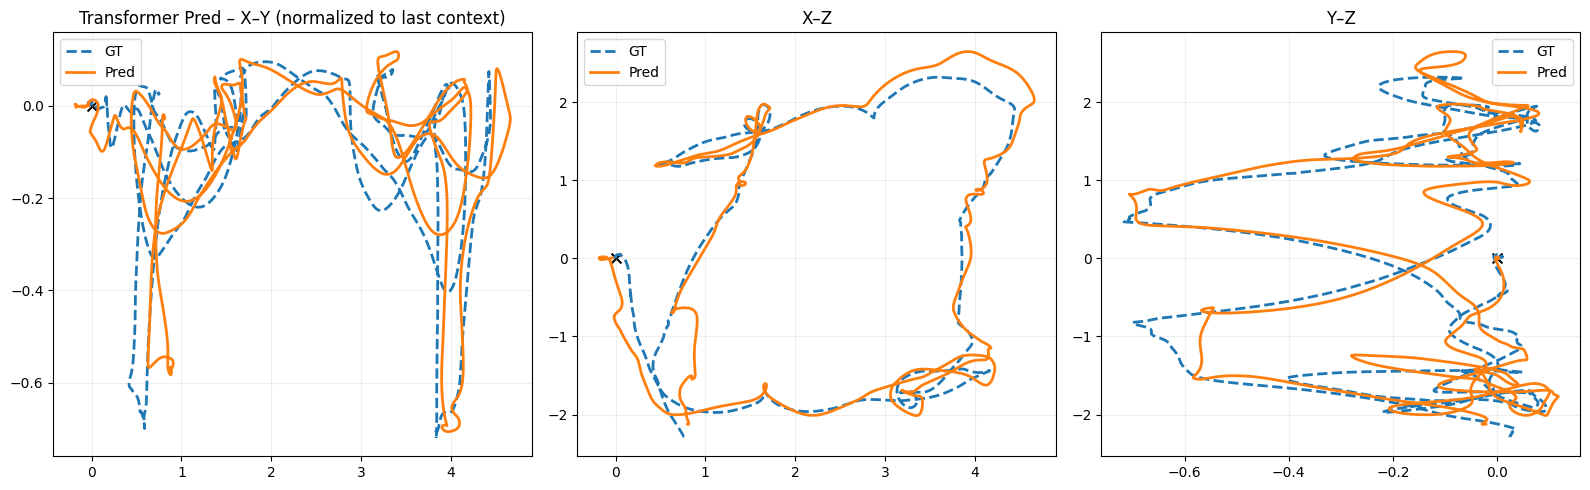

In [43]:
file_path = "/content/drive/MyDrive/Dance_clean_data/D9_All_CSVs/cleaned_Take 091517_Sub10_Circle3 01.12.49 PM edit.npy"
arr = np.load(file_path).astype(np.float32)
pred, mask = predict_transformer(arr, model_all, mu, sig, seq_in=30, seq_out=30, step=1, device=DEVICE)
plot_3d(arr, pred, title="Transformer Pred", xyz_idx=(16,17,18), normalize_to_last_context=True, ctx_len=30)
plot_2d(arr, pred, title="Transformer Pred", xyz_idx=(16,17,18), normalize_to_last_context=True, ctx_len=30)